# SVD improved algorithm

---
## Theory behind

### [KBV09] Yehuda Koren. Matrix factorization techniques for recommender systems.

see [Matrix Factorization techniques](https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf)

explicit feedback = (user,item, rating) represented as user-item matrix.

Matrix factorization models map both users and items to a joint latent factor space of dimensionality f, such that user-item interactions are modeled as inner products in that space.

Assume $r_{ui} = q_i^Tp_u$, how to compute $q_i, p_u$?

Want to minimize $min_{p_u, q_i} \sum_{x_{ui}}(r_{ui}-p_u^Tq_i)^2 + \lambda ($$ \lVert q_i \rVert $$^2 + $$ \lVert p_u \rVert $$^2)$

1. Can use SGD to optimize (see Simon Funk) <- focus here
2. Can use ALS (convexifies the objective)

__Adding Biases__:
some users tend to give higher/lower ratings then others. And some items tend to receive higher/lower ratings than others (relatively seen).

Bias involved in rating $r_{ui}$ is denoted by $b_{ui}$:<br/>
$b_{ui} = \mu + b_i + b_u$ <br/>
$\mu$: average rating over all movies <br/>
$b_i$: deviation of item i from average <br/>
$b_u$: deviation of user u from average <br/>

estimate of rating is: <br/>
$r_{ui} = \mu + b_i + b_u + q_i^Tp_u$

adjusted objective: <br/>
 $min_{p_u, q_i} \sum_{x_{ui}}(r_{ui}-\mu-b_u-b_i -p_u^Tq_i)^2 + \lambda ($$ \lVert q_i \rVert $$^2 + $$ \lVert p_u \rVert $$^2 + b_u^2 + b_i^2)$

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numbers

from scipy import stats
from six.moves import range
from __future__ import (absolute_import, division, print_function, unicode_literals)

from surprise_extensions import CustomReader, get_ratings_from_predictions
from surprise import Reader, Dataset
from surprise.model_selection.search import RandomizedSearchCV
from surprise import AlgoBase

import data_handler

## SVD algorithm implementation

The SVD algorithm was popularized by Simon Funk in his blog called [Netflix Update: Try this at home](http://sifter.org/simon/journal/20061211.html). The theory behind it, also described in the paper "Matrix factorization techniques for recommender systems" by Yehuda Koren, is summarized above.

Note: The code below is a modification/extension of the SVD implementation in the Surprise package http://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD

In [32]:
def get_rng(random_state):
        '''Return a 'validated' RNG. If random_state is None, use RandomState singleton from numpy.  Else if
        it's an integer, consider it's a seed and initialized an rng with that seed. If it's already an rng, return it.
        '''
        if random_state is None:
            return np.random.mtrand._rand
        elif isinstance(random_state, (numbers.Integral, np.integer)):
            return np.random.RandomState(random_state)
        if isinstance(random_state, np.random.RandomState):
            return random_state
        raise ValueError('Wrong random state. Expecting None, an int or a numpy '
                         'RandomState instance, got a '
                         '{}'.format(type(random_state)))

In [33]:
class SVD(AlgoBase):
    """The famous *SVD* algorithm, as popularized by Simon Funk.
    
    Args:
        n_factors: The number of factors. Default is ``100``.
        n_epochs: The number of iteration of the SGD procedure. Default is ``20``.
        biased(bool): Whether to use baselines (or biases). Default is ``True``.
        init_mean: The mean of the normal distribution for factor vectors initialization. Default is ``0``.
        init_std_dev: The standard deviation of the normal distribution for factor vectors initialization. Default is ``0.1``.
        lr_all: The learning rate for all parameters. Default is ``0.005``.
        reg_all: The regularization term for all parameters. Default is ``0.02``.
        random_state(int, RandomState instance from numpy, or ``None``):
            Determines the RNG that will be used for initialization. If int, ``random_state`` will be used as a seed for a new RNG. 
            This is useful to get the same initialization over multiple calls to ``fit()``.  
            If RandomState instance, this same instance is used as RNG. If ``None``, the current RNG from numpy is used.  
            Default is ``None``.
        verbose: If ``True``, prints the current epoch. Default is ``False``.
        
    Attributes:
        pu(numpy array of size (n_users, n_factors)): The user factors (only exists if ``fit()`` has been called)
        qi(numpy array of size (n_items, n_factors)): The item factors (only exists if ``fit()`` has been called)
        bu(numpy array of size (n_users)): The user biases (only exists if ``fit()`` has been called)
        bi(numpy array of size (n_items)): The item biases (only exists if ``fit()`` has been called)
        train_error(list of size (n_epochs)): List of training errors per epoch.
    """
   
    def __init__(self, n_factors=100, n_epochs=20, biased=True, init_mean=0, init_std_dev=.1, lr_all=.005, reg_all=.02, 
                 lr_bu=None, lr_bi=None, lr_pu=None, lr_qi=None, reg_bu=None, reg_bi=None, reg_pu=None, reg_qi=None,
                 random_state=None, verbose=False):

        self.n_factors = n_factors
        self.n_epochs = n_epochs
        self.biased = biased
        self.init_mean = init_mean
        self.init_std_dev = init_std_dev
        self.lr_bu = lr_bu if lr_bu is not None else lr_all
        self.lr_bi = lr_bi if lr_bi is not None else lr_all
        self.lr_pu = lr_pu if lr_pu is not None else lr_all
        self.lr_qi = lr_qi if lr_qi is not None else lr_all
        self.reg_bu = reg_bu if reg_bu is not None else reg_all
        self.reg_bi = reg_bi if reg_bi is not None else reg_all
        self.reg_pu = reg_pu if reg_pu is not None else reg_all
        self.reg_qi = reg_qi if reg_qi is not None else reg_all
        self.random_state = random_state
        self.verbose = verbose
        self.train_error = [] # list of train error per epoch

        AlgoBase.__init__(self)

    def fit(self, trainset):
        """Fit the model parameters to the training set.
        
        Args:
            trainset(Trainset): The training set which is used to fit the model.
        
        """
    
        AlgoBase.fit(self, trainset)
        self.sgd(trainset)

        return self
    
    def sgd(self, trainset):
        """This method is called by the fit method and performs the sgd steps which update the parameters.
         
        Args:
            trainset(Trainset): The training set which is used to fit the model.
        """
        
        global_mean = self.trainset.global_mean

        # local variables ofer some performance advantage over class member attributes.
        lr_bu = self.lr_bu
        lr_bi = self.lr_bi
        lr_pu = self.lr_pu
        lr_qi = self.lr_qi

        reg_bu = self.reg_bu
        reg_bi = self.reg_bi
        reg_pu = self.reg_pu
        reg_qi = self.reg_qi

        rng = get_rng(self.random_state)

        bu = np.zeros(trainset.n_users, np.double)
        bi = np.zeros(trainset.n_items, np.double)
        pu = rng.normal(self.init_mean, self.init_std_dev,
                        (trainset.n_users, self.n_factors))
        qi = rng.normal(self.init_mean, self.init_std_dev,
                        (trainset.n_items, self.n_factors))

        if not self.biased:
            global_mean = 0

        for current_epoch in range(self.n_epochs):
            if self.verbose:
                print("Processing epoch {}".format(current_epoch))
            train_error = 0
            for u, i, r in trainset.all_ratings():

                # compute current error
                dot = 0  # <q_i, p_u>
                for f in range(self.n_factors):
                    dot += qi[i, f] * pu[u, f]
                err = r - (global_mean + bu[u] + bi[i] + dot)
                train_error += abs(err)

                # update biases
                if self.biased:
                    bu[u] += lr_bu * (err - reg_bu * bu[u])
                    bi[i] += lr_bi * (err - reg_bi * bi[i])

                # update factors
                for f in range(self.n_factors):
                    puf = pu[u, f]
                    qif = qi[i, f]
                    pu[u, f] += lr_pu * (err * qif - reg_pu * puf)
                    qi[i, f] += lr_qi * (err * puf - reg_qi * qif)
                    
            self.train_error.append(train_error)

        self.bu = bu
        self.bi = bi
        self.pu = pu
        self.qi = qi

    def estimate(self, u, i):
        """Predict rating of user u and movie i.
        
        Args:
            u(int): user id
            i(int): movie id
        
        Returns:
            float: the predicted rating of user u and movie i. 
        """

        known_user = self.trainset.knows_user(u)
        known_item = self.trainset.knows_item(i)

        if self.biased:
            est = self.trainset.global_mean

            if known_user:
                est += self.bu[u]

            if known_item:
                est += self.bi[i]

            if known_user and known_item:
                est += np.dot(self.qi[i], self.pu[u])

        else:
            if known_user and known_item:
                est = np.dot(self.qi[i], self.pu[u])
            else:
                raise Exception('User and item are unkown.')

        return est
    

## Data loading

In [8]:
reader = CustomReader()
filepath = data_handler.get_train_file_path()
data = Dataset.load_from_file(filepath, reader=reader)

## Hyperparameter tuning


In [ ]:
param_grid = {  'n_factors': stats.randint(150,160),
                'lr_bu': stats.uniform(0.004,0.007),
                'lr_bi': stats.uniform(0.004,0.007),
                'lr_qi': stats.uniform(0.01,0.03),
                'lr_pu': stats.uniform(0.01,0.03),
                'reg_bi': stats.uniform(0.02,0.05),
                'reg_bu': stats.uniform(0.04,0.06),
                'reg_qi': stats.uniform(0.04,0.08),
                'reg_pu': stats.uniform(0.02,0.2),
                'init_std_dev': stats.uniform(0.01,0.8),
                'n_epochs': stats.randint(10,30)
             }         
        
# do cross validation to find the bast hyper parameters
gs = RandomizedSearchCV(algo_class=SVD, param_distributions=param_grid, measures=['rmse'], 
                        cv=10, joblib_verbose=100, n_jobs=-1, n_iter=100)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

In [ ]:
pd.DataFrame.from_dict(gs.cv_results)

## RMSE results for different parameters

Cross-validation over 10 folds.
Run on Leonhard cluster (20 cores and 22GB mem)


0.98460820897
{'lr_bi': 0.0045699937900061235, 'lr_bu': 0.0053470080935120153, 'lr_pu': 0.017294772891100464, 'lr_qi': 0.016495757165001537, 'n_epochs': 26, 'n_factors': 159, 'reg_bi': 0.026026359248845211, 'reg_bu': 0.099924883620357285, 'reg_pu': 0.10778441193893745, 'reg_qi': 0.071670616244315685}

0.98489843593
{'lr_bi': 0.0043688979424132048, 'lr_bu': 0.005613464182452876, 'lr_pu': 0.022148955075059311, 'lr_qi': 0.012530626289208299, 'n_factors': 151, 'reg_bi': 0.042342905803236859, 'reg_bu': 0.073415041823889998, 'reg_pu': 0.12513844856777867, 'reg_qi': 0.060228735604464054}

0.984953534195
{'lr_bi': 0.0040080904244357771, 'lr_bu': 0.0083752718099860367, 'lr_pu': 0.010813216008005243, 'lr_qi': 0.018992188100229335, 'n_factors': 158, 'reg_bi': 0.02384386240305832, 'reg_bu': 0.087957272220067495, 'reg_pu': 0.17370665665508969, 'reg_qi': 0.042977558957037719}

0.985070495179
{'init_std_dev': 0.031184006269592716, 'lr_bi': 0.0048978641284463517, 'lr_bu': 0.010989040837895429, 'lr_pu': 0.016034035470675671, 'lr_qi': 0.012197663818154646, 'n_factors': 151, 'reg_bi': 0.029524162229769623, 'reg_bu': 0.042540872922616352, 'reg_pu': 0.071567945780504169, 'reg_qi': 0.075092708208885889}

0.9853091859177997
{'lr_bi': 0.0050565201838808, 'lr_bu': 0.005529901817482, 'lr_pu': 0.021009781711363945, 'lr_qi': 0.019237920706921686, 'n_factors': 153, 'reg_bi': 0.027507293418947705, 'reg_bu': 0.04792231303919493, 'reg_pu': 0.1051659555261933, 'reg_qi': 0.05739791764348274}

0.985423383238
{'lr_bi': 0.0045872175952940859, 'lr_bu': 0.0059198576112051132, 'lr_pu': 0.03996299827445985, 'lr_qi': 0.012744793911701359, 'n_factors': 156, 'reg_bi': 0.039006956026578499, 'reg_bu': 0.058835165460011773, 'reg_pu': 0.065999449644116956, 'reg_qi': 0.11943136846519176}

0.98576635754
{'lr_bi': 0.004388787077144584, 'lr_bu': 0.0077070689204476878, 'lr_pu': 0.037207361664974598, 'lr_qi': 0.011526606878613951, 'n_factors': 155, 'reg_bi': 0.055491394820528769, 'reg_bu': 0.025510174666992846, 'reg_pu': 0.073005652506841268, 'reg_qi': 0.084369830119022798}

0.985920828862
{'lr_bi': 0.0061067123779277675, 'lr_bu': 0.005972391928230663, 'lr_pu': 0.023802281518036983, 'lr_qi': 0.016117532546202691, 'n_factors': 157, 'reg_bi': 0.013775300394299965, 'reg_bu': 0.034301808303089626, 'reg_pu': 0.09627118462747386, 'reg_qi': 0.061245371260615522}

0.986355638337
{'lr_bi': 0.0053921528073649578, 'lr_bu': 0.014983628487378223, 'lr_pu': 0.025070307435290061, 'lr_qi': 0.0073965320227803123, 'n_factors': 154, 'reg_bi': 0.027365169456015866, 'reg_bu': 0.03585534141987403, 'reg_pu': 0.15019357711020351, 'reg_qi': 0.050166823853083298}

0.986851655568
{'lr_bi': 0.0053647824382532638, 'lr_bu': 0.0052769550628727633, 'lr_pu': 0.012545946659482476, 'lr_qi': 0.012795461232426109, 'n_factors': 156, 'reg_bi': 0.056418600300998704, 'reg_bu': 0.022556567389521144, 'reg_pu': 0.061086848339968164, 'reg_qi': 0.077168605512323629}

0.9872175653005135
{'lr_bi': 0.006088703690766571, 'lr_bu': 0.012744554096322995, 'lr_pu': 0.012380073174962966, 'lr_qi': 0.009130873179651982, 'n_factors': 158, 'reg_bi': 0.012919509150189782, 'reg_bu': 0.036795609500178635, 'reg_pu': 0.10361453028270178, 'reg_qi': 0.048785998289016745}

0.988058743973
{'lr_bi': 0.0045634712043475644, 'lr_bu': 0.01064562075669161, 'lr_pu': 0.012470219046795966, 'lr_qi': 0.0069239309430058314, 'n_factors': 160, 'reg_bi': 0.038064835563680136, 'reg_bu': 0.083204917488220814, 'reg_pu': 0.044129727640422105, 'reg_qi': 0.083532754108250978}

0.9882588317180945
{'lr_bi': 0.005572132295112126, 'lr_bu': 0.010459976354655289, 'lr_pu': 0.012621031473530591, 'lr_qi': 0.009189138000229718, 'n_factors': 81, 'reg_bi': 0.09508515857935072, 'reg_bu': 0.08100593615106191, 'reg_pu': 0.08560885565821767, 'reg_qi': 0.06136778252645429}

0.9889400786056195
{'lr_bi': 0.00505521532063321, 'lr_bu': 0.012181115620042492, 'lr_pu': 0.0094679873549249, 'lr_qi': 0.00612337262019204, 'n_factors': 108, 'reg_bi': 0.023237810934149287, 'reg_bu': 0.09931980200620626, 'reg_pu': 0.07865295413390713, 'reg_qi': 0.04964170302513018}

0.9894911251394463
{'lr_bi': 0.006439713022658003, 'lr_bu': 0.005220730820427025, 'lr_pu': 0.012121360196274768, 'lr_qi': 0.010296116770652414, 'n_factors': 98, 'reg_bi': 0.07326008897853639, 'reg_bu': 0.0654521219387276, 'reg_pu': 0.07673672028564435, 'reg_qi': 0.07732908168371602}

0.992159817137
{'lr_all': 0.0088540357639887227, 'n_factors': 94, 'reg_all': 0.060980144283391415}

0.9922037152942101
{'lr_all': 0.009404839806784696, 'n_factors': 83, 'reg_all': 0.06361145065359476}

0.9923411994233705
{'lr_all': 0.009518436883800755, 'n_factors': 98, 'reg_all': 0.06448898038350545}

0.996356760492
{'lr_all': 0.0069735838056049675, 'n_factors': 16, 'reg_all': 0.040538641816816053}

0.996617863993
{'lr_all': 0.0080655611939959484, 'n_epochs': 19, 'n_factors': 9, 'reg_all': 0.042201220509606799}

0.996918766638
{'lr_all': 0.010438622204618025, 'n_factors': 16, 'reg_all': 0.069969144045048129}

0.998777808857
{'n_factors': 5}

0.999721712849
{'lr_all': 0.0048483945439183485, 'n_factors': 9}

1.00085021593
{'lr_all': 0.0035314408264436933, 'n_epochs': 19, 'n_factors': 50, 'reg_all': 0.027105037999075404}

1.00534587695
{'lr_all': 0.0034656840329879137, 'n_epochs': 10, 'n_factors': 42, 'reg_all': 0.12231592623013628}

1.00104676332
{'lr_all': 0.0066032381482039656, 'n_epochs': 17, 'n_factors': 107, 'reg_all': 0.036362623151074552}

1.00382744957
{'lr_all': 0.0045664408289589759, 'n_epochs': 12, 'n_factors': 9, 'reg_all': 0.04029560227746723}

## Train

In [34]:
# choose optimal params from above
n_epochs = 26
algo = SVD(n_factors=159, lr_bi=0.0045699937900061235, lr_bu=0.0053470080935120153, lr_pu=0.017294772891100464, lr_qi=0.016495757165001537, reg_bi=0.026026359248845211, reg_bu=0.099924883620357285, reg_pu=0.10778441193893745, reg_qi=0.071670616244315685, n_epochs=n_epochs)

# train the algorithm
algo.fit(data.build_full_trainset())

## Plot error over epochs

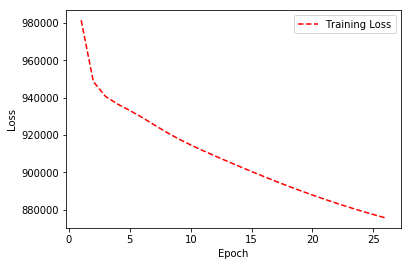

In [37]:
plt.plot(range(1,n_epochs+1), algo.train_error, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

## Predicting
We load the test data to predict.

In [ ]:
test_file_path = data_handler.get_test_file_path()
test_data = Dataset.load_from_file(test_file_path, reader=reader)
testset = test_data.construct_testset(test_data.raw_ratings)
predictions = algo.test(testset)

We need to convert the predictions into the right format.

In [ ]:
ratings = get_ratings_from_predictions(predictions)

Now we can write the file.

In [ ]:
output = data_handler.write_submission(ratings, 'submission_surprise_SVD_5.csv')